In [1]:
import os
import tensorflow
import tensorflow.keras
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, ReLU, Input, MaxPooling1D
from tensorflow.keras.models import Sequential

import numpy as np

/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorf

LOAD DATABASES, CONCATENATE AND MIX THEM

In [ ]:
path_db_0 = '/scratch/scarpolini/databases/db_lorenz_20.0_27.5.npy'
path_labels_0 = '/scratch/scarpolini/databases/lorenz_labels_20.0_27.5.npy'
path_db_1 = '/scratch/scarpolini/databases/db_lorenz_29.0_50.0.npy'
path_labels_1 = '/scratch/scarpolini/databases/lorenz_labels_29.0_50.0.npy'
path_db_2 = '/scratch/scarpolini/databases/db_lorenz_22.5_26.0.npy'
path_labels_2 = '/scratch/scarpolini/databases/lorenz_labels_22.5_26.0.npy'
path_db_3 = '/scratch/scarpolini/databases/db_lorenz_10.0_50.0.npy'
path_labels_3 = '/scratch/scarpolini/databases/lorenz_labels_10.0_50.0.npy'

db = np.load(path_db_3)
labels = np.load(path_labels_3)

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

db, labels = unison_shuffled_copies(db, labels)

In [64]:
#devo riadattare i labels ad essere 0 quando il segnale è r=20 e 1 quando r=27.5
new_labels = labels
for label, i in zip(labels, range(len(labels))):
    if label==10:
        new_labels[i] = 0
    elif label==50:
        new_labels[i] = 1
    else: print('problem')
labels = new_labels

PREPROCESSING

In [65]:
#(db_train), (db_test) = db[:80000,:,:], db[80000:,:,:]
# Normalize to between -1 and 1
db = db[:,:,0:1]
print(db.shape)
M = np.max(db)
m = np.min(db)
print(M,m)
db = (db - m)/(M - m)
M = np.max(db)
m = np.min(db)
print(M,m)

#db_train = db_train.reshape(-1, img_rows,img_cols,channels)
#x_train.shape

(100000, 2000, 1)
29.571612147237754 -29.81937884992222
1.0 0.0


VISUALIZE DATA

73240
1.0


IndexError: index 1 is out of bounds for axis 1 with size 1

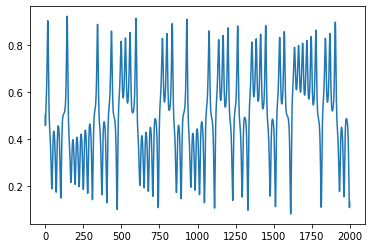

In [61]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
%matplotlib inline

n = round(np.random.uniform(100000))
#n = 35368
print(n)
traj = db[n,:,:]
print(labels[n])
plt.plot(traj[:,0])
plt.plot(traj[:,1])
plt.plot(traj[:,2])
plt.show()

#fig = plt.figure()
#ax = plt.axes(projection='3d')
#ax.plot3D(traj[:,0],traj[:,1],traj[:,2])

ARCHITETTURA RETE NEURALE

In [51]:
optimizer = Adam(0.0002, 0.5)
sig_len, channels = len(db[0,:,0]), len(db[0,0,:])
fs = 10 # dimensione filtro
fm = 8 # numero filtri
init_sigma = 0.02 # varianza distribuzione parametri iniziali dei kernel
def create_desc():
    discriminator = Sequential()
    #input:2000x1
    discriminator.add(Conv1D(fm, fs, strides=8, padding='same', activation='relu', kernel_initializer=RandomNormal(0, 0.02), input_shape=(sig_len, channels)))    
    #input:250x8
    discriminator.add(Conv1D(fm, fs, strides=8, padding='same', activation='relu', kernel_initializer=RandomNormal(0, 0.02)))    
    #input:32x8
    discriminator.add(Conv1D(fm, fs, strides=4, padding='same', activation='relu', kernel_initializer=RandomNormal(0, 0.02)))    
    #input:8x8
    discriminator.add(Flatten())
    #64x1
    discriminator.add(Dense(8*fm, activation='relu'))
    #64x1
    discriminator.add(Dense(2, activation='softmax'))
    #2x1
    discriminator.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return discriminator

desc = create_desc()

In [67]:
desc.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 250, 8)            88        
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 32, 8)             648       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 8, 8)              648       
_________________________________________________________________
flatten_4 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 130       
Total params: 5,674
Trainable params: 5,674
Non-trainable params: 0
____________________________________________________

TRAINING

In [53]:
#desc = create_desc()
class LossHistory(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
    
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

history = LossHistory()
fit_history = desc.fit(db, labels, batch_size=256, epochs=10, verbose=1, validation_split=0.33,
                       shuffle=False, callbacks=[history])

Train on 67000 samples, validate on 33000 samples
Epoch 1/10
67000/67000 [==============================] - 2s 31us/sample - loss: 0.5872 - acc: 0.6638 - val_loss: 0.4345 - val_acc: 0.7968
Epoch 2/10
67000/67000 [==============================] - 2s 28us/sample - loss: 0.4030 - acc: 0.8127 - val_loss: 0.3453 - val_acc: 0.8468
Epoch 3/10
67000/67000 [==============================] - 2s 26us/sample - loss: 0.2322 - acc: 0.9089 - val_loss: 0.1359 - val_acc: 0.9553
Epoch 4/10
67000/67000 [==============================] - 2s 27us/sample - loss: 0.1112 - acc: 0.9629 - val_loss: 0.0799 - val_acc: 0.9735
Epoch 5/10
67000/67000 [==============================] - 2s 25us/sample - loss: 0.0696 - acc: 0.9781 - val_loss: 0.0620 - val_acc: 0.9779
Epoch 6/10
67000/67000 [==============================] - 2s 25us/sample - loss: 0.0538 - acc: 0.9829 - val_loss: 0.0519 - val_acc: 0.9816
Epoch 7/10
67000/67000 [==============================] - 2s 24us/sample - loss: 0.0429 - acc: 0.9864 - val_loss: 0.

In [56]:
#desc.save('classificatore_binario_difficile_prova.h5')
#from tensorflow.keras.models import load_model
#desc = load_model('classificatore_binario_difficile_prova.h5')

TESTING

In [66]:
#n = round(np.random.uniform(0,10000))
desc.evaluate(db,labels)
#output = desc.predict(db[n:n+1000])
#for i in range(100):
#    print(f'{n+i:4}',end="\t")
#    print(f'{output[i][0]:1.2g}',end="\t")
#    print(f'{output[i][1]:1.2g}',end="\t")
#    print(f'{labels[n+i]:3}')

100000/100000 [==============================] - 5s 45us/sample - loss: 0.0264 - acc: 0.9909


[0.026421880822555394, 0.99095]

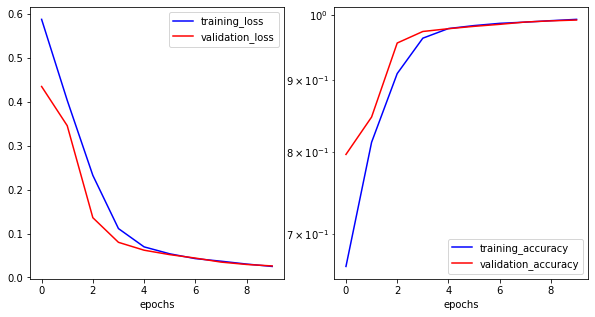

In [79]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
#epoch = fit_history.history
epoch = fit_history.history
ax1.set_xlabel("epochs")
ax2.set_xlabel("epochs")
plt.yscale('log')
ax1.plot(epoch['loss'], color="b",label="training_loss")
ax1.plot(epoch['val_loss'], color="r",label="validation_loss")
ax1.legend()
ax2.plot(epoch['acc'], color="b",label="training_accuracy")
ax2.plot(epoch['val_acc'], color="r",label="validation_accuracy")
ax2.legend()

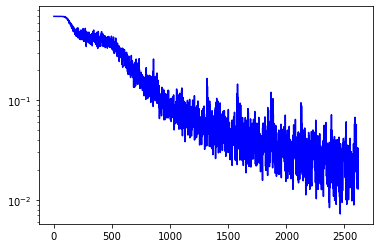

In [55]:
#fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
#epoch = fit_history.history
losses = history.losses
val_losses = history.val_losses
plt.yscale('log')
plt.plot(losses, color="b")
plt.plot(val_losses, color="r")
#ax2.plot(epoch['acc'], color="b")
#ax2.plot(epoch['val_acc'], color="r")

In [68]:
a = desc.get_weights()
for i in range(8): 
    print( a[i].shape )

(10, 1, 8)
(8,)
(10, 8, 8)
(8,)
(10, 8, 8)
(8,)
(64, 64)
(64,)


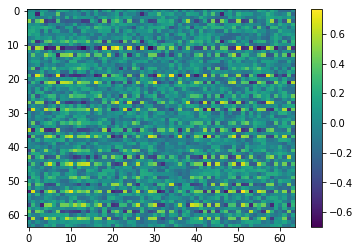

In [71]:
ciccio = a[6].reshape(64,-1)
import matplotlib.pyplot as plt
plt.imshow(ciccio, aspect="auto")
plt.colorbar()